In [2]:
## imports (dun remove)
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


In [3]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


##alphavantage specific
import os
import urllib
import json

In [4]:
# #get some data from kagggle/alphavantage
# data_source = 'alphavantage' # alphavantage or kaggle

# if data_source == 'alphavantage':
#     # ====================== Loading Data from Alpha Vantage ==================================

#     api_key = "A6YTTMQXU43PGRSS"

#     # American Airlines stock market prices
#     ticker = "AAL"

#     # JSON file with all the stock market data for AAL from the last 20 years
#     url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

#     # Save data to this file
#     file_to_save = 'stock_market_data-%s.csv'%ticker

#     # If you haven't already saved data,
#     # Go ahead and grab the data from the url
#     # And store date, low, high, volume, close, open values to a Pandas DataFrame
#     if not os.path.exists(file_to_save):
#         with urllib.request.urlopen(url_string) as url:
#             data = json.loads(url.read().decode())
#             # extract stock market data
#             print(data)
#             data = data['Time Series (Daily)']
#             df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
#             for k,v in data.items():
#                 date = dt.datetime.strptime(k, '%Y-%m-%d')
#                 data_row = [date.date(),float(v['3. low']),float(v['2. high']),
#                             float(v['4. close']),float(v['1. open'])]
#                 df.loc[-1,:] = data_row
#                 df.index = df.index + 1
#         print('Data saved to : %s'%file_to_save)        
#         df.to_csv(file_to_save)

#     # If the data is already there, just load it from the CSV
#     else:
#         print('File already exists. Loading data from CSV')
#         df = pd.read_csv(file_to_save)

# else:

#     # ====================== Loading Data from Kaggle ==================================
#     # You will be using HP's data. Feel free to experiment with other data.
#     # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
#     df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
#     print('Loaded data from the Kaggle repository')


In [5]:
df=pd.read_csv("TSLA.csv", parse_dates=['Date'])
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (251, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-27,241.083328,253.266663,240.176666,253.210007,253.210007,89295000
1,2022-05-31,257.946655,259.600006,244.743332,252.753326,252.753326,101914500
2,2022-06-01,251.720001,257.326660,243.639999,246.789993,246.789993,77247900
3,2022-06-02,244.156662,264.209991,242.066666,258.333344,258.333344,93473100
4,2022-06-03,243.226669,247.796661,233.416672,234.516663,234.516663,112393800


In [6]:
def load_data(company, start, end):
    """
    Load data for the specified company and date range.

    :param company: The company's stock symbol (str)
    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

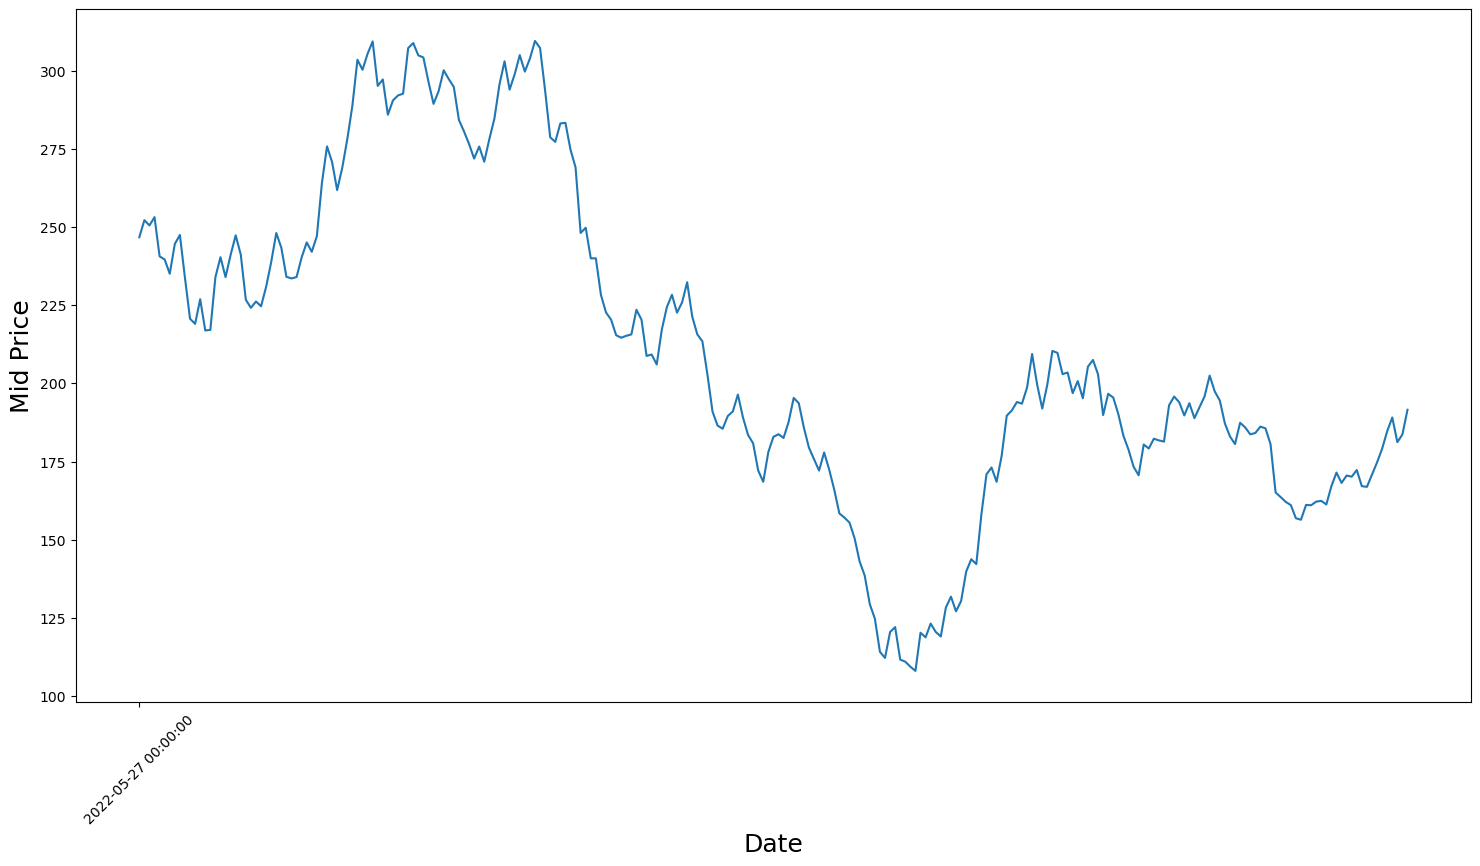

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0) #we take an average
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [8]:
##TODO, change the training set stuff!
training_set = df.iloc[:100, 1:2].values
test_set = df.iloc[100:, 1:2].values #take the last x values? (to predict!)

print(training_set.size)
print(test_set.size)

100
151


In [9]:
# Input features: time lag of 1 day
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 100):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
#(740, 60, 1)

(40, 60, 1)


In [20]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
2/2 [==============================] - 5s 39ms/step - loss: 0.3844
Epoch 2/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1784
Epoch 3/100
2/2 [==============================] - 0s 42ms/step - loss: 0.1059
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1461
Epoch 5/100
2/2 [==============================] - 0s 43ms/step - loss: 0.0849
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0971
Epoch 7/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0889
Epoch 8/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0923
Epoch 9/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0814
Epoch 10/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0885
Epoch 11/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1036
Epoch 12/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0908
Epoch 13/100
2/2 [==============================]

In [21]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:100, 1:2]
dataset_test = df.iloc[100:, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


print(dataset_total.shape)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 100):
    temp = inputs[i-60:i, 0:1] #40 segments of size 60 (0:59, 1:60...)
    X_test.append(temp)
X_test = np.array(X_test)
print(X_test.shape)
X_test = X_test.reshape((X_test.shape[0], -1))
#reshape into 3D model for LSTM 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
print(X_test.shape)
# (459, 60, 1)

(251, 1)
(40, 60, 1)
(40, 60, 1)


In [22]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 11ms/step


(140, 1)


ValueError: x and y must have same first dimension, but have shapes (40,) and (140, 1)

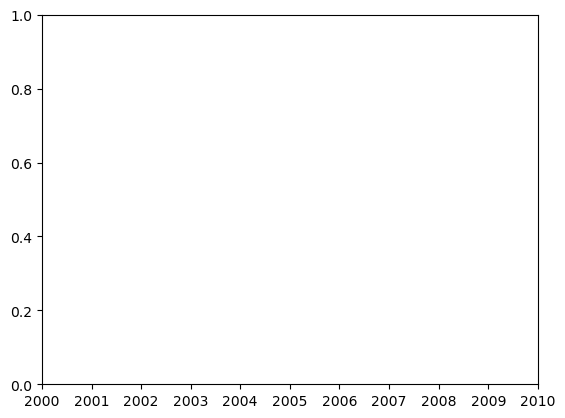

In [23]:
# Visualising the results
print(dataset_test.values[11:].shape)
plt.plot(df.loc[211:, "Date"],dataset_test.values[11:], color = "red", label = "Real TESLA Stock Price")
print(predicted_stock_price.shape)
plt.plot(df.loc[200:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,51,1))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

(40, 1)


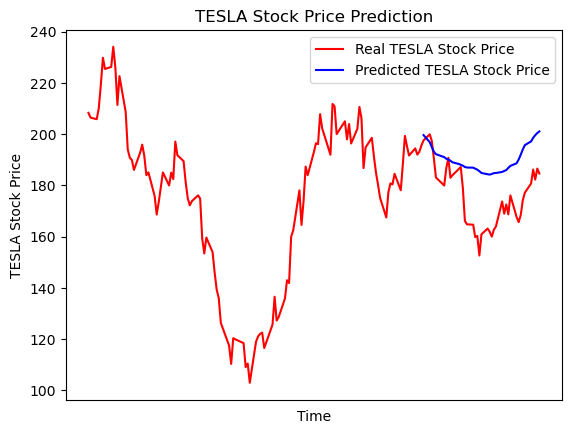

In [24]:
# Visualising the results
plt.plot(df.loc[100:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
print(predicted_stock_price.shape)
plt.plot(df.loc[211:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(140,1))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()